
BraTS2021_01557  –  (160, 192, 128, 4)  –  slice 93/127
          mask unique labels: [0 1 2 4]


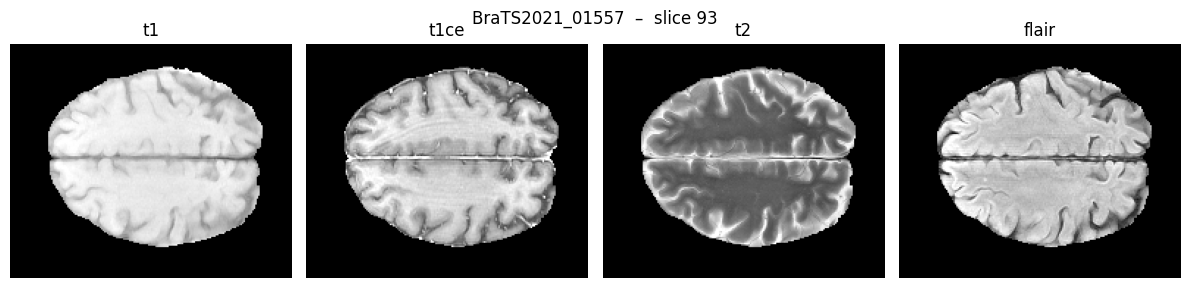


BraTS2021_01558  –  (160, 192, 128, 4)  –  slice 76/127
          mask unique labels: [0 2]


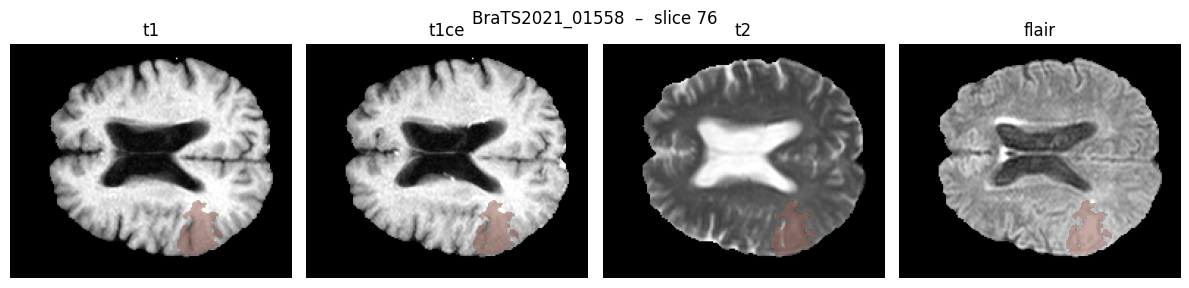


BraTS2021_01559  –  (160, 192, 128, 4)  –  slice 29/127
          mask unique labels: [0 2 4]


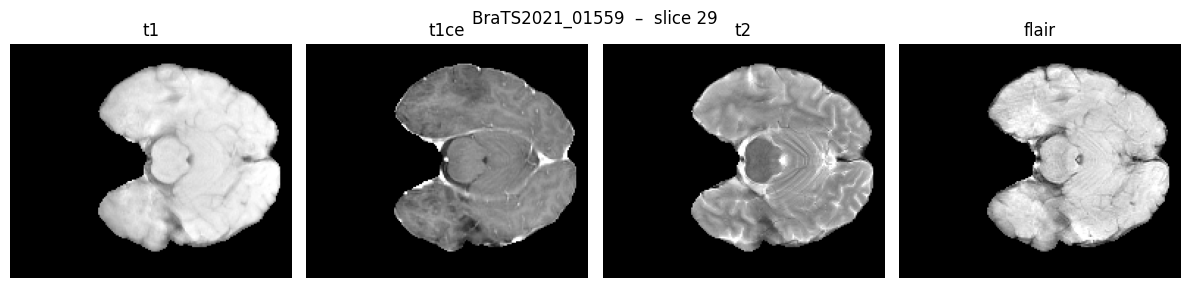

In [12]:
# %% 1. CONFIG ---------------------------------------------------------------
import os, json, time, hashlib, logging
from pathlib import Path

import numpy as np
import nibabel as nib
from skimage.transform import resize
import matplotlib.pyplot as plt

RAW_ROOT  = Path(r"D:\GitHub\NeuroLens\data\raw\Main_Training\Train")  # <-- change if necessary
PROC_ROOT = Path("data/processed/BraTS2021")
TARGET_VOXEL = np.array([1., 1., 1.])   # 1 mm iso
TARGET_SHAPE = (160, 192, 128)
MODALITIES   = ["t1", "t1ce", "t2", "flair"]

os.makedirs("log", exist_ok=True)
logging.basicConfig(
    filename="log/brats2021_3pats.log",
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
log = logging.getLogger()

# %% 2. FAST HELPERS ---------------------------------------------------------
def resample_to_iso(arr, affine, new_vox=TARGET_VOXEL, order=1):
    """Resize array to ~1 mm iso using pixel dimensions from affine."""
    vox_size = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))  # voxel size
    zoom = vox_size / new_vox
    new_shape = np.round(np.array(arr.shape) * zoom).astype(int)
    return resize(arr, new_shape, order=order, mode='reflect', anti_aliasing=True)

def crop_or_pad(arr, tgt=TARGET_SHAPE):
    cur = np.array(arr.shape)
    pad_pre  = np.maximum((tgt - cur) // 2, 0)
    pad_post = np.maximum(tgt - cur - pad_pre, 0)
    if np.any(pad_pre + pad_post > 0):
        arr = np.pad(arr, [(p, q) for p, q in zip(pad_pre, pad_post)], mode='constant')
    crop_pre = np.maximum((cur - tgt) // 2, 0)
    crop_post = crop_pre + tgt
    sl = tuple(slice(p, s) for p, s in zip(crop_pre, crop_post))
    return arr[sl]

def zscore(arr):
    m, s = arr.mean(), arr.std()
    return (arr - m) / s if s > 0 else arr

# %% 3. PROCESS ONE PATIENT --------------------------------------------------
def process_one(pid: str):
    pid_dir = RAW_ROOT / pid
    if not pid_dir.is_dir():
        log.error(f"{pid} directory not found")
        return None

    out_img = PROC_ROOT / "image" / pid / "image.npy"
    out_msk = PROC_ROOT / "mask"  / pid / "mask.npy"

    # ---- modalities ---------------------------------------------------------
    images = []
    for m in MODALITIES:
        f = list(pid_dir.glob(f"*{m}.nii.gz"))
        if not f:
            log.warning(f"{pid} missing {m}")
            return None
        img_nii = nib.load(f[0])
        arr = resample_to_iso(img_nii.get_fdata(dtype=np.float32), img_nii.affine, order=1)
        arr = crop_or_pad(arr)
        arr = zscore(arr)
        images.append(arr)
    img_stack = np.stack(images, axis=-1).astype(np.float32)

    # ---- segmentation -------------------------------------------------------
    seg_files = list(pid_dir.glob("*seg*.nii.gz"))
    if seg_files:
        seg_nii = nib.load(seg_files[0])
        mask = resample_to_iso(seg_nii.get_fdata(dtype=np.float32), seg_nii.affine, order=0)
        mask = crop_or_pad(mask).astype(np.uint8)
    else:
        mask = None

    # ---- save ---------------------------------------------------------------
    out_img.parent.mkdir(parents=True, exist_ok=True)
    np.save(out_img, img_stack)
    if mask is not None:
        out_msk.parent.mkdir(parents=True, exist_ok=True)
        np.save(out_msk, mask)

    log.info(f"{pid}  |  image {img_stack.shape}  |  mask {mask.shape if mask is not None else None}")
    return img_stack, mask

# %% 4. RUN 3 PATIENTS -------------------------------------------------------
PATS = ["BraTS2021_01557", "BraTS2021_01558", "BraTS2021_01559"]
results = {}
for pid in PATS:
    t0 = time.time()
    img, msk = process_one(pid) or (None, None)
    results[pid] = {"img": img, "msk": msk, "t": time.time() - t0}

# %% 5. FOUR-MODALITY RANDOM-SLICE DISPLAY (auto-contrast) -------------------
import random

for pid, d in results.items():
    if d["img"] is None:
        print(f"{pid}  –  skipped")
        continue

    n_slices = d["img"].shape[2]
    mid_z = random.randint(0, n_slices - 1)

    print(f"\n{pid}  –  {d['img'].shape}  –  slice {mid_z}/{n_slices-1}")
    if d["msk"] is not None:
        print(f"          mask unique labels: {np.unique(d['msk'])}")

    mods = ["t1", "t1ce", "t2", "flair"]
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    for i, m in enumerate(mods):
        sl = d["img"][:, :, mid_z, i]
        # robust intensity window: 0.5-th → 99.5-th percentile
        p0, p99 = np.percentile(sl, [0.5, 99.5])
        ax[i].imshow(sl, cmap="gray", vmin=p0, vmax=p99)
        if d["msk"] is not None:
            ax[i].imshow(np.ma.masked_where(d["msk"][:, :, mid_z] == 0,
                                            d["msk"][:, :, mid_z]),
                         cmap="tab10", alpha=0.5, vmin=0, vmax=4)
        ax[i].axis("off")
        ax[i].set_title(m)
    fig.suptitle(f"{pid}  –  slice {mid_z}", y=0.95)
    plt.tight_layout()
    plt.show()

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\evilk\anaconda3\envs\tdsenv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:

AttributeError: _ARRAY_API not found

[]


: 